<a href="https://colab.research.google.com/github/Chinmaya-3141/Capstone-Project/blob/main/Capstone_Object_Detection_Debugged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Detection using Pytorch Faster RCNN Resnet-50-FPN model**

## Install, import necessary packages, global variables

In [ ]:
%%time
!pip install torchinfo -qq

CPU times: user 26.1 ms, sys: 5.63 ms, total: 31.8 ms
Wall time: 4.02 s


In [ ]:
%%time
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' -qq

  Preparing metadata (setup.py) ... done
CPU times: user 31.7 ms, sys: 11.4 ms, total: 43.1 ms
Wall time: 4.73 s


In [ ]:
%%time
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 322034, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 322034 (delta 4), reused 8 (delta 1), pack-reused 322014
Receiving objects: 100% (322034/322034), 653.59 MiB | 34.29 MiB/s, done.
Resolving deltas: 100% (296026/296026), done.
CPU times: user 437 ms, sys: 80.2 ms, total: 517 ms
Wall time: 57.5 s


In [ ]:
# Mount Drive to import Data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 

In [ ]:
import os
import random
import math
import sys
import time
import tqdm
from tqdm import trange
import shutil
from skimage import io
import cv2
from albumentations.pytorch import ToTensorV2
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip,
                            Normalize,Flip, Compose, GaussNoise)
# import albumentations as A

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn as fasterrcnn
from torch.utils.data import DataLoader, Dataset
from torchvision import utils
from torchvision import transforms
from torchinfo import summary as tisum
from torch.optim import AdamW, RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# from engine import train_one_epoch, evaluate
# from torchvision.models.detection import retinanet_resnet50_fpn as retinanet
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
# from torch.utils.data.sampler import SequentialSampler
# from torchvision.models.detection.transform import GeneralizedRCNNTransform as g_trans

In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
# To improve reproducibility

def seed_everything(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
seed_everything(42)

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


In [ ]:
batchsize = 8
channels = 3
dimension = 640
learning_rate = 0.005
weight_decay = 10e-3

## Import, Explore Data

In [ ]:
csv_path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/For Object Detection/Object_detection_640_corrected.csv'
train_dir = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/For Object Detection/Combined_640_images of Covid and Pneumonia _for FasterRCNN'

In [ ]:
df = pd.read_csv(csv_path)
df.head(16)

,filename,width,height,bbox,label,xmin,ymin,xmax,ymax,box_w,box_h
0,COVID-100.png,640,640,"[204, 192, 478, 530]",covid,204,192,478,530,274,338
1,COVID-101.png,640,640,"[196, 140, 484, 444]",covid,196,140,484,444,288,304
2,COVID-103.png,640,640,"[166, 140, 462, 482]",covid,166,140,462,482,296,342
3,COVID-104.png,640,640,"[192, 158, 490, 508]",covid,192,158,490,508,298,350
4,COVID-105.png,640,640,"[152, 122, 432, 516]",covid,152,122,432,516,280,394
5,COVID-106.png,640,640,"[182, 134, 436, 496]",covid,182,134,436,496,254,362
6,COVID-107.png,640,640,"[198, 138, 470, 464]",covid,198,138,470,464,272,326
7,COVID-108.png,640,640,"[234, 232, 474, 514]",covid,234,232,474,514,240,282
8,COVID-109.png,640,640,"[200, 162, 458, 514]",covid,200,162,458,514,258,352
9,COVID-10.png,640,640,"[190, 180, 492, 504]",covid,190,180,492,504,302,324


In [ ]:
# Checking the data

print(f'Total number of train images is {len(os.listdir(train_dir))}')
print(f'shape of dataframe is {df.shape}')
print(f'Number of images in dataframe is {len(np.unique(df["filename"]))}')
print(f'Number of train images with no bounding boxes {len(os.listdir(train_dir)) - len(np.unique(df["filename"]))}')

Total number of train images is 925
shape of dataframe is (2601, 12)
Number of images in dataframe is 925
Number of train images with no bounding boxes 0


In [ ]:
# If images without bounding boxes exist, list them

for var in os.listdir(train_dir):
  if var not in np.unique(df["filename"]):
    print(var)

In [ ]:
df['label'].unique()

array(['covid', 'pneumonia'], dtype=object)

In [ ]:
# Label encoding classes

enc = preprocessing.LabelEncoder()
df['enc_labels'] = enc.fit_transform(df['label'])   # label encode classes 0-1
df['enc_labels'] = np.stack(df['enc_labels'][i]+1 for i in range(len(df['enc_labels'])))    # label encode classes 1-2

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
classes = df[['label','enc_labels']].value_counts()
classes

label      enc_labels
pneumonia  2             1492
covid      1             1109
dtype: int64

In [ ]:
# make dictionary for class objects so we can call objects by their keys.
classes= {0:'background', 1:'covid',2:'pneumonia'}

In [ ]:
df.head()

,filename,width,height,bbox,label,xmin,ymin,xmax,ymax,box_w,box_h,enc_labels
0,COVID-100.png,640,640,"[204, 192, 478, 530]",covid,204,192,478,530,274,338,1
1,COVID-101.png,640,640,"[196, 140, 484, 444]",covid,196,140,484,444,288,304,1
2,COVID-103.png,640,640,"[166, 140, 462, 482]",covid,166,140,462,482,296,342,1
3,COVID-104.png,640,640,"[192, 158, 490, 508]",covid,192,158,490,508,298,350,1
4,COVID-105.png,640,640,"[152, 122, 432, 516]",covid,152,122,432,516,280,394,1


## Stratified sampling

In [ ]:
df['filename'].nunique()

925

In [ ]:
# Split the data in roughly equal proportions of each class into train and test in given ratio (80-20 usually).

def stratified_sampling(dataframe, proportion, column_name, filename):
    # Group the dataframe by the column and filename to split based on
    grouped_dataframe = dataframe.groupby([column_name, filename])
    
    # Initialize empty dataframes for the training and validation sets
    train_dataframe = pd.DataFrame()
    val_dataframe = pd.DataFrame()
    
    # Loop through each group and add the entire group to either the training or validation dataframe,
    # depending on a randomly generated value for that group
    for _, group in grouped_dataframe:
        if random.random() >= proportion: # Stochastic element introduced here
            val_dataframe = pd.concat([val_dataframe, group])
        else:
            train_dataframe = pd.concat([train_dataframe, group])
    
    # Reset the index of the dataframes
    train_dataframe = train_dataframe.reset_index(drop=True)
    val_dataframe = val_dataframe.reset_index(drop=True)
    
    return train_dataframe, val_dataframe


In [ ]:
# Count the number of images for covid and pneumonia in split dataframe

def count_unique_filenames(df):
    # Filter the DataFrame to only include rows with "covid" or "pneumonia" labels
    covid_pneumonia_df = df[df['label'].isin(['covid', 'pneumonia'])]

    # Count the number of unique filenames with "covid" and "pneumonia" labels separately
    covid_filenames = covid_pneumonia_df[covid_pneumonia_df['label'] == 'covid']['filename'].nunique()
    pneumonia_filenames = covid_pneumonia_df[covid_pneumonia_df['label'] == 'pneumonia']['filename'].nunique()

    # Print output
    print(f"Unique filenames with Covid label:", covid_filenames)
    print(f"Unique filenames with Pneumonia label:", pneumonia_filenames)

    return covid_filenames, pneumonia_filenames

In [ ]:
# Split the dataframe and images

train, val = stratified_sampling(df,0.8,'label','filename')

In [ ]:
# Check if any filenames coincide

for i in train['filename']:
  if(i in val['filename']):
    print(i)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    2062 non-null   object
 1   width       2062 non-null   int64 
 2   height      2062 non-null   int64 
 3   bbox        2062 non-null   object
 4   label       2062 non-null   object
 5   xmin        2062 non-null   int64 
 6   ymin        2062 non-null   int64 
 7   xmax        2062 non-null   int64 
 8   ymax        2062 non-null   int64 
 9   box_w       2062 non-null   int64 
 10  box_h       2062 non-null   int64 
 11  enc_labels  2062 non-null   int64 
dtypes: int64(9), object(3)
memory usage: 193.4+ KB


In [ ]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    539 non-null    object
 1   width       539 non-null    int64 
 2   height      539 non-null    int64 
 3   bbox        539 non-null    object
 4   label       539 non-null    object
 5   xmin        539 non-null    int64 
 6   ymin        539 non-null    int64 
 7   xmax        539 non-null    int64 
 8   ymax        539 non-null    int64 
 9   box_w       539 non-null    int64 
 10  box_h       539 non-null    int64 
 11  enc_labels  539 non-null    int64 
dtypes: int64(9), object(3)
memory usage: 50.7+ KB


In [ ]:
cf_total,pf_total = count_unique_filenames(df)

Unique filenames with Covid label: 479
Unique filenames with Pneumonia label: 446


In [ ]:
cf_train, pf_train = count_unique_filenames(train)

Unique filenames with Covid label: 383
Unique filenames with Pneumonia label: 355


In [ ]:
cf_val, pf_val = count_unique_filenames(val)

Unique filenames with Covid label: 96
Unique filenames with Pneumonia label: 91


In [ ]:
print(f"Covid (fraction of total data): {round((cf_total/(cf_total + pf_total))*100,3)}%")
print(f"Pneumonia (fraction of total data): {round((pf_total/(cf_total + pf_total))*100,3)}%")

Covid (fraction of total data): 51.784%
Pneumonia (fraction of total data): 48.216%


In [ ]:
print(f"Covid Train (fraction of covid): {round((cf_train/cf_total)*100,3)}%, Pneumonia Train (fraction of pneumonia): {round((pf_train/pf_total)*100,3)}%")
print(f"Covid Train (fraction of train): {round((cf_train/(cf_train + pf_train))*100,3)}%, Pneumonia Train (fraction of train): {round((pf_train/(cf_train+pf_train))*100,3)}%")

Covid Train (fraction of covid): 79.958%, Pneumonia Train (fraction of pneumonia): 79.596%
Covid Train (fraction of train): 51.897%, Pneumonia Train (fraction of train): 48.103%


In [ ]:
print(f"Covid Test(fraction of covid): {round((cf_val/cf_total)*100,3)}%, Pneumonia Test (fraction of pneumonia): {round((pf_val/pf_total)*100,3)}%")
print(f"Covid Test (fraction of validation): {round((cf_val/(cf_val + pf_val))*100,3)}%, Pneumonia Test (fraction of validation): {round((pf_val/(cf_val+pf_val))*100,3)}%")

Covid Test(fraction of covid): 20.042%, Pneumonia Test (fraction of pneumonia): 20.404%
Covid Test (fraction of validation): 51.337%, Pneumonia Test (fraction of validation): 48.663%


In [ ]:
A = df[df['filename']== 'COVID-113.png']['label'].values
A

array(['covid', 'covid'], dtype=object)

## Transforms, Custom DatasetClass, Dataloader

In [ ]:
def get_transform():
    list_transforms = []
    # converts the input image, which should be a PIL image, into a PyTorch Tensor
    list_transforms.append(transforms.ToTensor())
    
    #keeping space for augmentations in future
    
    return transforms.Compose(list_transforms)

**Getitem returns for EACH image:**

1.   **image** - a PIL image of size (H,W) 

    for ResNet50 FPN image should be scaled

2.   **target** - a dictionary containing the following fields

    1. ***Boxes*** as FloatTensor of dimensions - (N,4) 
      
      here, N = number of bounding boxs within an image and the 4 columns include [x_min, y_min, x_max, y_max]
    2. ***Labels*** as Int64Tensor of dimension - N

    3. ***Area*** as Int64Tensor of dimension - N

    4. ***Iscrowd*** as UInt8Tensor of dimension - N

3. (removed) **image_id** - Name of the image


In [ ]:
class XrayData(Dataset):
    def __init__(self,input_df,input_dir,transforms=None):
        super().__init__()
        self.df=input_df    
        self.list_images = list(self.df['filename'].unique())
        self.image_dir=input_dir
        self.transforms = transforms
        self.label_mapping = {0: "background", 1: "covid", 2: "pneumonia"}

    def __len__(self):
        return len(self.df['filename'].unique())

    def get_label_mapping(self):
        return self.label_mapping

    def __getitem__(self,idx):
                
        cols_to_be_selected =['xmin','ymin','xmax','ymax']
        img_id = self.list_images[idx]
        bboxes_array = np.array(self.df.loc[self.df['filename']==img_id,cols_to_be_selected])
        boxes = torch.tensor(bboxes_array, dtype=torch.float32)
        
        num_boxes = self.df.loc[self.df['filename']==img_id].shape[0]
        label = self.df[self.df['filename']== img_id]['enc_labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        area = torch.tensor(np.array((self.df['xmax']-self.df['xmin'])*(self.df['ymax']-self.df['ymin'])), dtype=torch.int64)

        iscrowd = torch.zeros(num_boxes, dtype=torch.uint8)
        
        # Combining everything
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
                
        # img = cv2.imread(os.path.join(self.image_dir, img_id), 0)  # 0 for grayscale
        img = cv2.imread(self.image_dir+'/'+img_id, cv2.IMREAD_COLOR)
        img_col = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_scaled = img_col / 255.0
        img_final = img_scaled

        if self.transforms is not None:
            img_final = self.transforms(img_final)
                
        return img_final, target

In [ ]:
train_dataset = XrayData(train,train_dir,get_transform())
val_dataset = XrayData(val,train_dir,get_transform())

In [ ]:
print(f'Length of train data {len(train_dataset)}')
print(f'Length of validation data {len(val_dataset)}')

Length of train data 738
Length of validation data 187


In [ ]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_dataset,
    batch_size=batchsize,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx) # Has (image, target, image_id) for idx
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy() # target boxes coordinates to numpy
    sample = out[1]['labels'].numpy()
    print(data.label_mapping)
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    for idx, i in enumerate(sample):
        label = data.label_mapping[i]
        x, y = int(bb[idx][0]), int(bb[idx][1])
        cv2.putText(image, label, (x, y-5), cv2.FONT_HERSHEY_COMPLEX, 0.7, (220,0,0), 1, cv2.LINE_AA)  

    plt.figure(figsize=(10,10))
    plt.imshow(image)

In [ ]:
# train_dataset[124]

(tensor([[[0.3529, 0.3490, 0.3490,  ..., 0.1804, 0.1725, 0.1725],
          [0.3529, 0.3529, 0.3490,  ..., 0.1843, 0.1765, 0.1765],
          [0.3529, 0.3529, 0.3490,  ..., 0.1882, 0.1843, 0.1843],
          ...,
          [0.6000, 0.6000, 0.6000,  ..., 0.5020, 0.5020, 0.5020],
          [0.6039, 0.6039, 0.6039,  ..., 0.4980, 0.4980, 0.4941],
          [0.6078, 0.6078, 0.6039,  ..., 0.4980, 0.4941, 0.4941]],
 
         [[0.3529, 0.3490, 0.3490,  ..., 0.1804, 0.1725, 0.1725],
          [0.3529, 0.3529, 0.3490,  ..., 0.1843, 0.1765, 0.1765],
          [0.3529, 0.3529, 0.3490,  ..., 0.1882, 0.1843, 0.1843],
          ...,
          [0.6000, 0.6000, 0.6000,  ..., 0.5020, 0.5020, 0.5020],
          [0.6039, 0.6039, 0.6039,  ..., 0.4980, 0.4980, 0.4941],
          [0.6078, 0.6078, 0.6039,  ..., 0.4980, 0.4941, 0.4941]],
 
         [[0.3529, 0.3490, 0.3490,  ..., 0.1804, 0.1725, 0.1725],
          [0.3529, 0.3529, 0.3490,  ..., 0.1843, 0.1765, 0.1765],
          [0.3529, 0.3529, 0.3490,  ...,

{0: 'background', 1: 'covid', 2: 'pneumonia'}


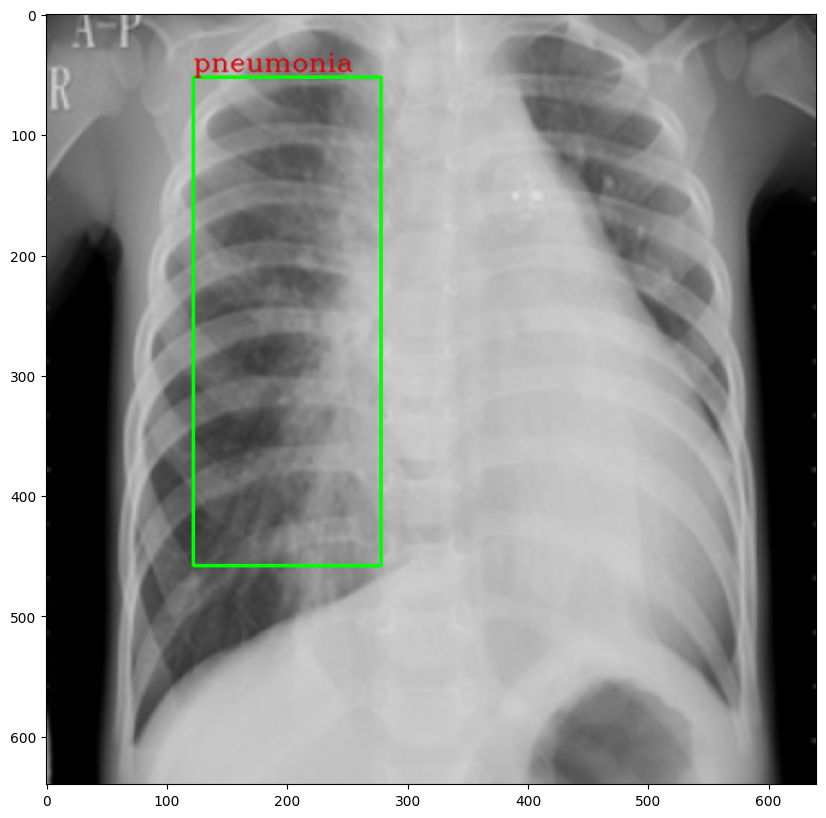

In [ ]:
plot_img(val_dataset,124)

## Training a model, Saving model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
# define the number of classes
num_classes = 3  # COVID, pneumonia, background

# load a pre-trained model
model = fasterrcnn(pretrained=True)

# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
print(tisum(
    model, 
    input_size = (batchsize,channels,dimension,dimension),
    depth =6
    ))

In [ ]:
%%time
# let's train it for 2 epochs
num_epochs = 10

for epoch in trange(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    
    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

    # Write code to save model here
    # torch.save(model.state_dict(), 'faster_rcnn_state.pt')

In [ ]:
torch.save(model.state_dict(), 'faster_rcnn_state.pt')

## Load a model, Prediction

In [ ]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "/content/faster_rcnn_state.pt"

num_classes = 3

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

In [ ]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

    detection_threshold = 0.70
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

In [ ]:
pred_path = "/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/For Object Detection/Combined_640_images of Covid and Pneumonia _for FasterRCNN"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

start = 750
plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i < start:
      pass
    elif i in range(start+1,start+10):
        plt.subplot(10,2,i-start)
        names,boxes,sample = obj_detector(images)
        for i,box in enumerate(boxes):
            cv2.rectangle(sample,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0, 220, 0), 2)
            cv2.putText(sample, data.label_mapping[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

        plt.axis('off')
        plt.imshow(sample)